# Encoder-Only Transformer


</br></br>

### Import Data and Libraries
---

In [ ]:
!pip install word-piece-tokenizer
!pip install wikipedia

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.9/119.9 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11679 sha256=47f1916857fbddfd19af38184a81588d70e4ec5e6e14dd088285b6d71c0ecd67
  Stored in directory: /root/.cache/pip/wheels/5e/b6/c5/93f3dec388ae76edc830cb42901bb0232504dfc0df02fc50de
Successfully built wikipedia


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from word_piece_tokenizer import WordPieceTokenizer
from collections import Counter, defaultdict
import re
import wikipedia

In [ ]:
def extract_wikipedia_text(page_title):
    try:
        page = wikipedia.page(page_title)
        return page.content
    except wikipedia.exceptions.PageError:
        print(f"Page not found: {article}")
        return ""
    except wikipedia.exceptions.DisambiguationError as e:
        return f"Disambiguation page: {e}"

text = ""
articles = ["Apollo 12", "NASA", "Heliophysics",
            "Nuclear fusion", "Greenwich Mean Time", "United Kingdom",
            "English people", "Air raids on Japan", "Maya civilization",
            "Manhattan Project", "Elvis Presley", "Country music",
            "Trumpet", "Byzantine navy", "India",
            "Climate_change", "Dinosaur"]

for article in articles:
  text += extract_wikipedia_text(article)

/usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.10/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


In [ ]:
text_len = len(text)
train_text = text[:int(0.75 * text_len)]
test_text  = text[int(0.75 * text_len):]

print(train_text[11000:12000])

lo 10 had been postponed a day so ALS-2 could be photographed under proper conditions. ALS-2 was chosen as the lunar landing site since it was relatively smooth, of scientific interest, and ALS-1 was deemed too far to the east. Thus, when Apollo 10's launch date was announced on January 10, 1969, it was shifted from its placeholder date of May 1 to May 17, rather than to May 16. On March 17, 1969, the launch was slipped one day to May 18, to allow for a better view of ALS-3, to the west of ALS-2. Another deviation from the plans for Apollo 11 was that Apollo 10 was to spend an additional day in lunar orbit once the CSM and LM rendezvoused; this was to allow time for additional testing of the LM's systems, as well as for photography of possible future Apollo landing sites.
The Apollo 10 astronauts undertook five hours of formal training for each hour of the mission's eight-day duration. This was in addition to the normal mission preparations such as technical briefings, pilot meetings a

In [ ]:
BATCH_SIZE    = 32
EPOCHS        = 50
EMB_DIM       = 64
SEQ_LEN       = 20
IGNORE_LEN    = 20
NUM_HEADS     = 8
NUM_BLOCKS    = 4
LEARNING_RATE = 3e-4
DEVICE        = 'cuda' if torch.cuda.is_available() else 'cpu'

</br></br>

### Preprocess Text + EDA
---

In [ ]:
tokenizer = WordPieceTokenizer()

In [ ]:
for i in range(500):
  if tokenizer.convert_ids_to_tokens([i])[0] == "[MASK]":
    print(i)

103


In [ ]:
def tokenize_text(text):
  sentences = re.split(r'[.!?]', text)
  tokenizer = WordPieceTokenizer()
  ids       = [tokenizer.tokenize(i) for i in sentences \
                      if len(tokenizer.tokenize(i)) > 2]
  return ids

In [ ]:
tokens = tokenize_text(text)

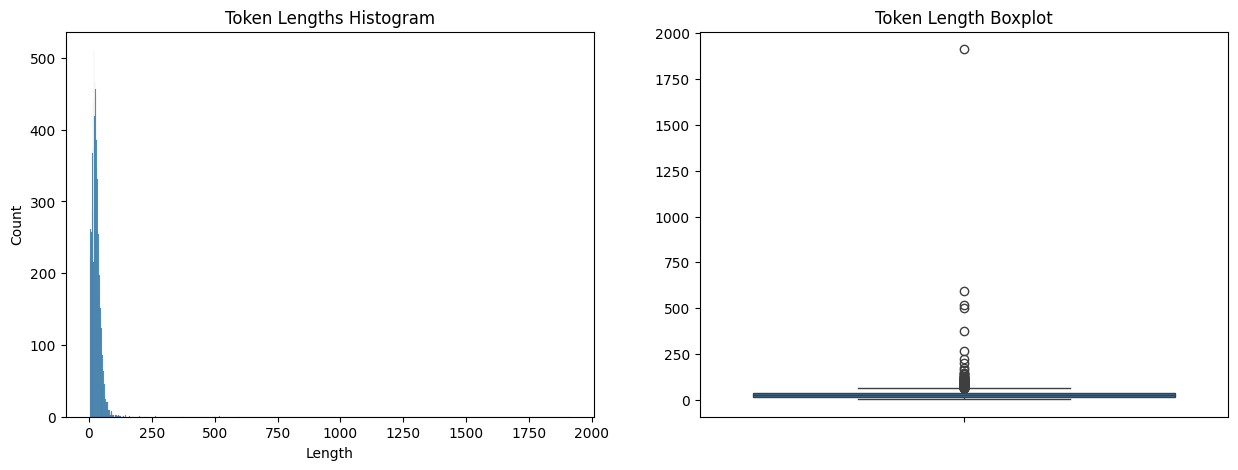

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.histplot([len(i) for i in tokens])
plt.title("Token Lengths Histogram")
plt.xlabel("Length")
plt.grid(False)

plt.subplot(1, 2, 2)
sns.boxplot([len(i) for i in tokens])
plt.title("Token Length Boxplot")
plt.grid(False)

In [ ]:
token_counter = Counter()
for i in tokens:
  token_counter.update(i)

<ipython-input-196-26121686a81f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=real_tokens, y=counts, palette='viridis')


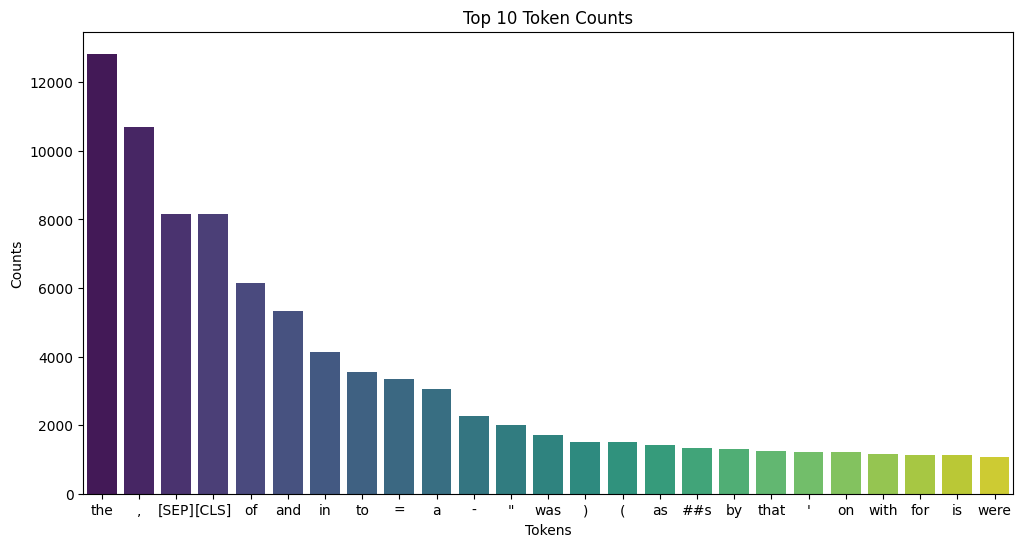

In [ ]:
token_count_list = [[v, tokenizer.convert_ids_to_tokens([i])] for i,v in token_counter.items()]
token_count_list.sort(reverse=True)

top_tokens  = token_count_list[:25]
real_tokens = [t[1][0] for t in top_tokens]
counts      = [t[0] for t in top_tokens]

plt.figure(figsize=(12, 6))
sns.barplot(x=real_tokens, y=counts, palette='viridis')

plt.xlabel('Tokens')
plt.ylabel('Counts')
plt.title('Top 10 Token Counts');

In [ ]:
def pad_sequences(tokens, pad_len, len_to_ignore):
  new_tokens = []
  for i in range(len(tokens)):
    if len(tokens[i]) > len_to_ignore:
      new_len = pad_len - len(tokens[i])
      if new_len >= 0:
        new_tokens.append(tokens[i][:-1] + ([0] * (new_len)) + [tokens[i][-1]])
      else:
        new_tokens.append(tokens[i][:pad_len - 1] + [tokens[i][-1]])

  return torch.tensor(new_tokens)

In [ ]:
tokens_padded = pad_sequences(tokens, SEQ_LEN, IGNORE_LEN)

In [ ]:
for i in range(3):
  tokens_i = tokens_padded[i].detach().cpu().numpy()
  print(f"----- Sentence {i + 1} -----")
  print(tokens_i)
  print(tokenizer.convert_ids_to_tokens(tokens_i))
  print("\n\n")

----- Sentence 1 -----
[  101  9348  2184  1006  2089  2324  1516  2656  1010  3440  1007  2001
  1996  2959  2529  2686 28968  1999  1996   102]
['[CLS]', 'apollo', '10', '(', 'may', '18', '–', '26', ',', '1969', ')', 'was', 'the', 'fourth', 'human', 'space', '##flight', 'in', 'the', '[SEP]']



----- Sentence 2 -----
[  101  9274  1010  1996  3260  1005  1055  6872  1010  2649  2009  2004
  1037  1000  4377 17887  1000  2005  1996   102]
['[CLS]', 'nasa', ',', 'the', 'mission', "'", 's', 'operator', ',', 'described', 'it', 'as', 'a', '"', 'dress', 'rehearsal', '"', 'for', 'the', '[SEP]']



----- Sentence 3 -----
[  101  2009  2001  4351  2019  1000  1042  1000  3260  1010  3832  2000
  3231  2035 12076  6177  1998  8853  2460   102]
['[CLS]', 'it', 'was', 'designated', 'an', '"', 'f', '"', 'mission', ',', 'intended', 'to', 'test', 'all', 'spacecraft', 'components', 'and', 'procedures', 'short', '[SEP]']





In [ ]:
def generate_sentence_pairs(sentences):
  new_sentences = []
  for i in range(len(sentences) - 1):
    cur_sentence = [sentences[i]]
    cur_sentence.append(sentences[i + 1])
    new_sentences.append(cur_sentence)

  return new_sentences

In [ ]:
tokens_paired = generate_sentence_pairs(tokens_padded)

In [ ]:
for i in range(3):
  tokens_i_0 = tokens_paired[i][0].detach().cpu().numpy()
  tokens_i_1 = tokens_paired[i][1].detach().cpu().numpy()
  print(f"----- Sentence Pair {i + 1} -----")
  print(tokenizer.convert_ids_to_tokens(tokens_i_0))
  print(tokenizer.convert_ids_to_tokens(tokens_i_1))
  print("\n\n")

----- Sentence Pair 1 -----
['[CLS]', 'apollo', '10', '(', 'may', '18', '–', '26', ',', '1969', ')', 'was', 'the', 'fourth', 'human', 'space', '##flight', 'in', 'the', '[SEP]']
['[CLS]', 'nasa', ',', 'the', 'mission', "'", 's', 'operator', ',', 'described', 'it', 'as', 'a', '"', 'dress', 'rehearsal', '"', 'for', 'the', '[SEP]']



----- Sentence Pair 2 -----
['[CLS]', 'nasa', ',', 'the', 'mission', "'", 's', 'operator', ',', 'described', 'it', 'as', 'a', '"', 'dress', 'rehearsal', '"', 'for', 'the', '[SEP]']
['[CLS]', 'it', 'was', 'designated', 'an', '"', 'f', '"', 'mission', ',', 'intended', 'to', 'test', 'all', 'spacecraft', 'components', 'and', 'procedures', 'short', '[SEP]']



----- Sentence Pair 3 -----
['[CLS]', 'it', 'was', 'designated', 'an', '"', 'f', '"', 'mission', ',', 'intended', 'to', 'test', 'all', 'spacecraft', 'components', 'and', 'procedures', 'short', '[SEP]']
['[CLS]', 'after', 'the', 'spacecraft', 'reached', 'lunar', 'orbit', ',', 'astronaut', 'john', 'young', 're

In [ ]:
def prepare_nsp(sentences):
  sent_len  = int(len(sentences) * 0.5)
  new_len   = sent_len - (sent_len % 2)

  switch_idx = torch.randint(0, len(sentences), (new_len,))

  for i in range(new_len - 1):
    idx_1, idx_2 = switch_idx[i], switch_idx[i + 1]
    sentences[idx_1][1], sentences[idx_2][1] = (sentences[idx_2][1],
                                                sentences[idx_1][1])

  new_sentences = []
  for i in range(len(sentences)):
    pair_1, pair_2 = sentences[i][0], sentences[i][1]
    new_sentences.append(list(pair_1.detach().cpu().numpy()))
    new_sentences[-1].extend(list(pair_2.detach().cpu().numpy()[1:]))

  nsp_labels = torch.ones((len(new_sentences),))
  nsp_labels[switch_idx] = 0
  return new_sentences, nsp_labels

In [ ]:
tokens_nsp, nsp_labels = prepare_nsp(tokens_paired)

In [ ]:
print(tokens_nsp[0])

[101, 9348, 2184, 1006, 2089, 2324, 1516, 2656, 1010, 3440, 1007, 2001, 1996, 2959, 2529, 2686, 28968, 1999, 1996, 102, 9274, 1010, 1996, 3260, 1005, 1055, 6872, 1010, 2649, 2009, 2004, 1037, 1000, 4377, 17887, 1000, 2005, 1996, 102]


In [ ]:
for i in range(2, 5):
  print(f"----- NSP Seqeunce {((i + 1) % 3) + 1} -----")
  print(tokens_nsp[i])
  print(tokenizer.convert_ids_to_tokens(tokens_nsp[i]))
  print(f"NSP Label: {nsp_labels[i].item()}")
  print("\n\n")

----- NSP Seqeunce 1 -----
[101, 2009, 2001, 4351, 2019, 1000, 1042, 1000, 3260, 1010, 3832, 2000, 3231, 2035, 12076, 6177, 1998, 8853, 2460, 102, 2044, 1996, 12076, 2584, 11926, 8753, 1010, 19748, 2198, 2402, 2815, 1999, 1996, 3094, 1998, 2326, 11336, 1006, 102]
['[CLS]', 'it', 'was', 'designated', 'an', '"', 'f', '"', 'mission', ',', 'intended', 'to', 'test', 'all', 'spacecraft', 'components', 'and', 'procedures', 'short', '[SEP]', 'after', 'the', 'spacecraft', 'reached', 'lunar', 'orbit', ',', 'astronaut', 'john', 'young', 'remained', 'in', 'the', 'command', 'and', 'service', 'module', '(', '[SEP]']
NSP Label: 1.0



----- NSP Seqeunce 2 -----
[101, 2044, 1996, 12076, 2584, 11926, 8753, 1010, 19748, 2198, 2402, 2815, 1999, 1996, 3094, 1998, 2326, 11336, 1006, 102, 1022, 22484, 1007, 1997, 1996, 11926, 3302, 1010, 1996, 2391, 2012, 2029, 6113, 6934, 2005, 4899, 2052, 4088, 102]
['[CLS]', 'after', 'the', 'spacecraft', 'reached', 'lunar', 'orbit', ',', 'astronaut', 'john', 'young', 're

In [ ]:
def prepare_mlm(tokens):
  token_tensors    = torch.tensor(tokens)
  original_tensors = torch.tensor(tokens)

  total_len  = token_tensors.shape[0] * token_tensors.shape[1]
  masked_num = int(0.15 * total_len)
  mask_len, preserve_len = int(0.8 * masked_num), int(0.1 * masked_num)

  B, T = token_tensors.shape
  flattened = token_tensors.flatten()

  mask_idx = torch.randint(0,   len(flattened),  (mask_len,))
  pres_idx = torch.randint(0,   len(flattened),  (preserve_len,))
  rand_val = torch.randint(103, flattened.max(), (preserve_len,))

  masked_labels = torch.zeros_like(flattened)
  masked_labels[mask_idx] = flattened[mask_idx]
  masked_labels[pres_idx] = flattened[pres_idx]

  flattened[mask_idx] = 103
  flattened[pres_idx] = rand_val

  return flattened.view((B, T)), masked_labels.view((B, T))

In [ ]:
tokens_mlm, mlm_labeled_tokens = prepare_mlm(tokens_nsp)

In [ ]:
for i in range(3):
  print(f"----- MLM Seqeunce {(i + 1)} -----")
  print(tokenizer.convert_ids_to_tokens(tokens_mlm[i].detach().cpu().numpy()))
  print(tokenizer.convert_ids_to_tokens(mlm_labeled_tokens[i].detach().cpu().numpy()))
  print("\n\n")

----- MLM Seqeunce 1 -----
['[CLS]', 'apollo', '10', '(', 'may', '[MASK]', '–', '[MASK]', ',', '1969', ')', 'seminary', 'the', 'fourth', '[MASK]', 'space', '##flight', 'in', 'the', '[SEP]', 'nasa', ',', '[MASK]', 'mission', '[MASK]', 's', 'operator', ',', 'described', 'it', 'as', 'a', '"', 'dress', 'rehearsal', '"', 'for', 'the', '[SEP]']
['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '18', '[PAD]', '26', '[PAD]', '[PAD]', '[PAD]', 'was', '[PAD]', '[PAD]', 'human', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 'the', '[PAD]', "'", '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']



----- MLM Seqeunce 2 -----
['[CLS]', 'nasa', ',', 'the', 'mission', '[MASK]', 's', '[MASK]', ',', 'described', 'it', 'as', 'a', '"', 'dress', 'rehearsal', '"', 'for', 'the', '[SEP]', '[MASK]', '[MASK]', '2010', ',', 'viva', 'elvis', ':', 'the', 'album', 'was', 'released', ',', '[MASK]', 'his', 'voice', '[MASK]', 'new

In [ ]:
tokens_mlm[0]

tensor([  101,  9348,  2184,  1006,  2089,   103,  1516,   103,  1010,  3440,
         1007,  8705,  1996,  2959,   103,  2686, 28968,  1999,  1996,   102,
         9274,  1010,   103,  3260,   103,  1055,  6872,  1010,  2649,  2009,
         2004,  1037,  1000,  4377, 17887,  1000,  2005,  1996,   102])

In [ ]:
def final_sequences(token_tensors, token_tensor_labels, nsp_labels):
  bad = set()
  for (idx, i) in enumerate(token_tensors):
    c = Counter()
    c.update(i.detach().cpu().numpy())
    if c[101] > 1 or c[101] < 1 or c[102] > 2 or c[102] < 2:
      bad.add(idx)

  new_tensor = []
  new_tensor_labels = []
  new_nsp_labels = []
  for i in range(len(token_tensors)):
    if i not in bad:
      new_tensor.append(token_tensors[i])
      new_tensor_labels.append(token_tensor_labels[i])
      new_nsp_labels.append(nsp_labels[i])

  new_tensor = torch.stack(new_tensor)
  new_tensor_labels = torch.stack(new_tensor_labels)
  new_nsp_labels = torch.stack(new_nsp_labels)

  return new_tensor, new_tensor_labels, new_nsp_labels

In [ ]:
fin_tokens, fin_mlm_labels, fin_nsp_labels = final_sequences(tokens_mlm,
                                         mlm_labeled_tokens, nsp_labels)

In [ ]:
for i in range(3):
  print(f"----- Final Seqeunce {(i + 1)} -----")
  print(tokenizer.convert_ids_to_tokens(fin_tokens[i].detach().cpu().numpy()))
  print(tokenizer.convert_ids_to_tokens(fin_mlm_labels[i].detach().cpu().numpy()))
  print(fin_nsp_labels[i].item())
  print("\n\n")

----- Final Seqeunce 1 -----
['[CLS]', 'apollo', '10', '(', 'may', '[MASK]', '–', '[MASK]', ',', '1969', ')', 'seminary', 'the', 'fourth', '[MASK]', 'space', '##flight', 'in', 'the', '[SEP]', 'nasa', ',', '[MASK]', 'mission', '[MASK]', 's', 'operator', ',', 'described', 'it', 'as', 'a', '"', 'dress', 'rehearsal', '"', 'for', 'the', '[SEP]']
['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '18', '[PAD]', '26', '[PAD]', '[PAD]', '[PAD]', 'was', '[PAD]', '[PAD]', 'human', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 'the', '[PAD]', "'", '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
1.0



----- Final Seqeunce 2 -----
['[CLS]', 'nasa', ',', 'the', 'mission', '[MASK]', 's', '[MASK]', ',', 'described', 'it', 'as', 'a', '"', 'dress', 'rehearsal', '"', 'for', 'the', '[SEP]', '[MASK]', '[MASK]', '2010', ',', 'viva', 'elvis', ':', 'the', 'album', 'was', 'released', ',', '[MASK]', 'his', 'voice', '[MASK

In [ ]:
class BERTDataset(Dataset):
  def __init__(self, text, pad_len, ignore_len):
    tokens      = tokenize_text(text)
    pad_tokens  = pad_sequences(tokens, pad_len, ignore_len)
    sent_pairs  = generate_sentence_pairs(pad_tokens)
    nsp_tokens, nsp_labels = prepare_nsp(sent_pairs)
    mlm_tokens, mlm_labels = prepare_mlm(nsp_tokens)
    fin_tokens, fin_labels, nsp_labels = final_sequences(mlm_tokens,
                                             mlm_labels, nsp_labels)

    self.fin_tokens = fin_tokens.to(DEVICE)
    self.fin_labels = fin_labels.to(DEVICE)
    self.nsp_labels = nsp_labels.to(DEVICE)

  def __len__(self):
    return self.fin_tokens.shape[0]

  def __getitem__(self, idx):
    return (self.fin_tokens[idx],
            self.fin_labels[idx],
            self.nsp_labels[idx])

In [ ]:
train_data = DataLoader(BERTDataset(train_text, SEQ_LEN, IGNORE_LEN),  batch_size=BATCH_SIZE, shuffle=True)
test_data  = DataLoader(BERTDataset(test_text,  SEQ_LEN, IGNORE_LEN),  batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
tokenizer = WordPieceTokenizer()

for (idx, (x,y,z)) in enumerate(train_data):
  for sentence in x:
    print(tokenizer.convert_ids_to_tokens(x[0].detach().cpu().numpy()))
    print(tokenizer.convert_ids_to_tokens(y[0].detach().cpu().numpy()))
    print(z[0].detach().cpu().numpy())
    break
  break

['[CLS]', 'it', 'is', 'not', 'known', 'if', '[MASK]', 'members', 'of', 'the', 'aristocracy', 'could', 'read', 'and', 'write', ',', 'although', 'at', 'least', '[SEP]', 'however', ',', 'because', '[MASK]', 'fusion', '[MASK]', '[MASK]', 'much', 'faster', 'than', 'the', '[MASK]', 'ions', ',', 'they', 'will', 'realistic', 'up', '[SEP]']
['[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 'all', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 'the', '[PAD]', 'products', 'move', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 'fuel', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 'give', '[PAD]', '[PAD]']
0.0


</br></br>

### Create Transformer Encoder Architecture
---

In [ ]:
class FFNN(nn.Module):
  def __init__(self, emb_dim, hidden_dim):
    super().__init__()
    self.l1 = nn.Linear(emb_dim, hidden_dim)
    self.l2 = nn.Linear(hidden_dim, emb_dim)

  def forward(self, x):
    o1 = F.gelu(self.l1(x))
    o2 = F.gelu(self.l2(o1))

    return o2


class AttentionHead(nn.Module):
  def __init__(self, emb_dim, att_dim):
    super().__init__()
    self.d_k   = att_dim
    self.query = nn.Linear(emb_dim, att_dim)
    self.key   = nn.Linear(emb_dim, att_dim)
    self.value = nn.Linear(emb_dim, att_dim)

  def forward(self, x):
    Q = self.query(x)
    K = self.key(x)
    V = self.value(x)

    normalize = torch.sqrt(torch.tensor(self.d_k))
    K_T = torch.transpose(K, -1, -2)
    att_scores = F.softmax((Q @ K_T) / normalize, dim=-1) @ V

    return att_scores


class MultiHeadAttention(nn.Module):
  def __init__(self, emb_dim, num_heads):
    super().__init__()
    att_dim = emb_dim // num_heads
    self.att_heads = nn.ModuleList(
        [AttentionHead(emb_dim, att_dim) for i in range(num_heads)]
    )

  def forward(self, x):
    att_outs = []
    for attention_head in self.att_heads:
      output = attention_head(x)
      att_outs.append(output)

    output_concat = torch.cat(att_outs, dim=-1)
    return output_concat


class TransformerBlock(nn.Module):
  def __init__(self, emb_dim, num_heads):
    super().__init__()
    self.multi_head_att = MultiHeadAttention(emb_dim, num_heads)
    self.ln1  = nn.LayerNorm(emb_dim)
    self.ffnn = FFNN(emb_dim, emb_dim * 4)
    self.ln2  = nn.LayerNorm(emb_dim)

  def forward(self, x):
    att_out = self.multi_head_att(x)
    o1      = self.ln1(att_out + x)
    nn_out  = self.ffnn(o1)
    o2      = self.ln2(nn_out + o1)

    return o2


class BERT(nn.Module):
  def __init__(self, emb_dim, vocab_size, seq_len, num_heads):
    super().__init__()
    self.emb       = nn.Embedding(vocab_size, emb_dim)
    self.seg_emb   = nn.Embedding(2, emb_dim)
    self.pos_emb   = nn.Embedding(seq_len, emb_dim)
    self.blocks    = nn.ModuleList([TransformerBlock(emb_dim, num_heads)\
                                             for i in range(NUM_BLOCKS)])
    self.l_out     = nn.Linear(emb_dim, vocab_size)
    self.nsp_out   = nn.Linear(vocab_size, 1)
    self.dropout   = nn.Dropout(0.2)

  def forward(self, x):
    B, T = x.shape
    x_emb   = self.emb(x)

    seg_idx = torch.zeros((T,))
    seg_idx[T // 2 ::] = 1
    seg_idx = seg_idx.to(DEVICE)
    x_seg = self.seg_emb(seg_idx.int())

    pos_idx = torch.tensor(range(x.shape[1])).to(DEVICE)
    pos_emb = self.pos_emb(pos_idx)

    x = x_emb + pos_emb + x_seg

    for block in self.blocks:
      x = block(x)

    transformer_out = self.dropout(x)

    logits = self.l_out(transformer_out)
    probs  = F.softmax(logits, dim=-1)

    nsp_out  = self.nsp_out(logits[:,0,:])
    nsp_pred = F.sigmoid(nsp_out)

    return nsp_pred, probs

</br></br>

### Train Encoder Transformer
---

In [ ]:
vocab_size = 0
for x, _, _ in train_data:
  vocab_size = max(vocab_size, x.max())
vocab_size += 1
vocab_size

tensor(29735, device='cuda:0')

In [ ]:
model = BERT(EMB_DIM, vocab_size, (SEQ_LEN * 2) - 1, NUM_HEADS).to(DEVICE)
optim = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
total_params = 0
for i in model.parameters():
  total_params += i.numel()

total_params

4051471

In [ ]:
def train_iteration(model, optim, x, y_mlm, y_nsp):
  nsp_pred, output = model(x)
  B, T, C = output.shape

  y_nsp     = y_nsp.view((-1, 1))
  nsp_loss  = F.binary_cross_entropy(nsp_pred, y_nsp)

  x_flat   = x.reshape((-1))
  indices  = torch.nonzero(x_flat == 103, as_tuple=False).squeeze()
  mlm_loss = F.cross_entropy(output.view((-1, C))[indices],
                                   y_mlm.view(-1)[indices])

  loss = nsp_loss + mlm_loss

  optim.zero_grad()
  loss.backward()
  optim.step()

  return nsp_loss.item(), mlm_loss.item(), loss.item()

In [ ]:
overall_losses = []
for epoch in range(EPOCHS):
  iteration = 0
  losses    = []
  for x, y_mlm, y_nsp in train_data:
    nsp_loss, mlm_loss, loss = train_iteration(model, optim,
                                               x, y_mlm, y_nsp)

    losses.append([nsp_loss, mlm_loss, loss])
    overall_losses.append([nsp_loss, mlm_loss, loss])
    iteration += 1

  losses = torch.tensor(losses)
  nsp_avg, mlm_avg, loss_avg = (losses[:,0].mean(),
                                losses[:,1].mean(),
                                losses[:,2].mean())

  print(f"EPOCH: {epoch}  |  NSP LOSS: {round(nsp_avg.item(), 3)} \
  |  MLM LOSS: {round(mlm_avg.item(), 3)}  \
  |  LOSS: {round(loss_avg.item(),    3)}")

EPOCH: 0  |  NSP LOSS: 0.801   |  MLM LOSS: 10.3    |  LOSS: 11.101
EPOCH: 1  |  NSP LOSS: 0.752   |  MLM LOSS: 10.3    |  LOSS: 11.052
EPOCH: 2  |  NSP LOSS: 0.787   |  MLM LOSS: 10.3    |  LOSS: 11.087
EPOCH: 3  |  NSP LOSS: 0.743   |  MLM LOSS: 10.3    |  LOSS: 11.043
EPOCH: 4  |  NSP LOSS: 0.802   |  MLM LOSS: 10.3    |  LOSS: 11.102
EPOCH: 5  |  NSP LOSS: 0.719   |  MLM LOSS: 10.3    |  LOSS: 11.019
EPOCH: 6  |  NSP LOSS: 0.773   |  MLM LOSS: 10.3    |  LOSS: 11.073
EPOCH: 7  |  NSP LOSS: 0.705   |  MLM LOSS: 10.3    |  LOSS: 11.005
EPOCH: 8  |  NSP LOSS: 0.736   |  MLM LOSS: 10.3    |  LOSS: 11.037
EPOCH: 9  |  NSP LOSS: 0.709   |  MLM LOSS: 10.3    |  LOSS: 11.009
EPOCH: 10  |  NSP LOSS: 0.712   |  MLM LOSS: 10.3    |  LOSS: 11.012
EPOCH: 11  |  NSP LOSS: 0.692   |  MLM LOSS: 10.3    |  LOSS: 10.992
EPOCH: 12  |  NSP LOSS: 0.664   |  MLM LOSS: 10.3    |  LOSS: 10.964
EPOCH: 13  |  NSP LOSS: 0.632   |  MLM LOSS: 10.3    |  LOSS: 10.932
EPOCH: 14  |  NSP LOSS: 0.58   |  MLM LOSS: 

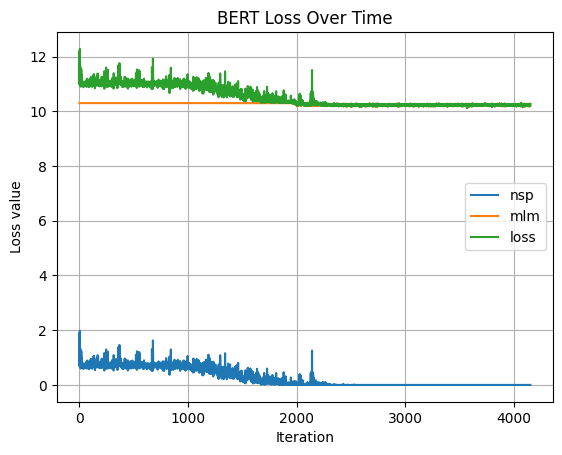

In [ ]:
overall_losses = torch.tensor(overall_losses)
nsp_losses     = overall_losses[:,0].detach().cpu().numpy()
mlm_losses     = overall_losses[:,1].detach().cpu().numpy()
total_losses   = overall_losses[:,2].detach().cpu().numpy()

plt.plot(nsp_losses,     label='nsp')
plt.plot(mlm_losses,     label='mlm')
plt.plot(total_losses,   label='loss')
plt.xlabel("Iteration")
plt.ylabel("Loss value")
plt.title("BERT Loss Over Time")
plt.grid(True)
plt.legend();

In [ ]:
with torch.no_grad():
  idx = 5
  for x,y,z in train_data:
    print(tokenizer.convert_ids_to_tokens(x[idx].detach().cpu().numpy())[1::])
    output = model(x)[1]
    print(tokenizer.convert_ids_to_tokens(torch.argmax(output, dim=-1).detach().cpu().numpy()[idx]))
    print(tokenizer.convert_ids_to_tokens(y.detach().cpu().numpy()[idx]))
    break

['[MASK]', 'the', 'late', 'pre', '##class', '##ic', ',', 'this', '[MASK]', 'pitching', 'in', 'the', 'institution', 'of', '[MASK]', 'divine', 'king', ',', '[SEP]', 'there', 'were', 'thirteen', 'levels', 'suggesting', 'the', 'heavens', '[MASK]', 'nine', 'in', 'the', 'underworld', '[MASK]', 'with', '[MASK]', 'mortal', 'world', 'in', '[SEP]']
['##uh', 'the', 'the', 'the', 'the', 'storylines', 'the', 'the', 'the', 'the', 'the', 'abortion', 'the', 'the', 'the', 'the', 'matthews', 'the', 'the', 'the', 'the', 'the', 'the', '##rangle', 'the', 'the', 'baronet', 'the', 'the', 'bravery', 'the', 'the', 'the', 'the', 'the', 'the', '##ttle', 'the', 'keen']
['[PAD]', 'in', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 'process', 'culminated', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 'the', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', 'in', '[PAD]', '[PAD]', 'and', '[PAD]', '[PAD]', '[PAD]', '[PAD]', ',', '[PAD]', 'the', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


</br></br>

### Fine-tuning BERT
---